# Perturbation Mean Squared Error (P-MSE)

### Given one or more points, a model and a function of interest, this script computes:
### (i) SmoothHess, SmoothGrad, SoftPluss Hess, SoftPlus Grad and Vanilla Grad 
### (ii) P-MSE of each method for the points

### The Script As Is Below Runs in ~20 mins on an NVIDIA V100 32GB. Control number of points evaluated with hop variable.

In [3]:
import pandas as pd
import numpy as np
import torch 
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time 

# Local Imports 
from Datasets import * 
from Models import * 
from ComputeDerivatives import Generate_Grad_Hess_From_List
from Evaluation import Compute_PMSE

4.50.0


# For User To Choose:
### Dataset, Function of Interest, Number of points to evaluate, Radius, Sigma and Beta 

In [32]:
dataset = "FMNIST" # Choose Dataset From: { MNIST, FMNIST or CIFAR10 }
function = "Logit" # Choose Function Of Interest From: { Logit, SoftMax, Penult_X} where X is the desired integer index of any penultimate neuron 
ind = 0  # Starting index for eval
hop = 200 # Number of points to eval i.e. ind = 1 hop = 10 --> points used index: 10, 11, 12, ..., 19 
rs = [0.5]  ####### Radius of interest for P-MSE , include in list format 

##### Smoothing Method Hyperparameters ############
sigma = 1.8e-4 # SmoothHess SmoothGrad Hyperparamter  --- 1.8e-4 is best found value for FMNIST Logit for SmoothGrad and SmoothHess + SmoothGrad @ r = 0.5
beta = 160     # SoftPlus Hyperparameter ----- 200 is best found value for FMNIST Logit for SoftPlus Hess + SoftPlus Grad  @ r = 0.5 
##########################################


t = time.time() 

## Config
### Includes Reccomended configs for each dataset

In [33]:
# Reccomended Loadouts for Each Dataset
if dataset == "MNIST":
    args = {
        "function_use" : function, 
        "iterations" : 10,
        "n1" : 5000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000, 
        "valstart" : 50000,
        "OriginalDim" : (784,)
    }

    # Used to construct network 
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    PMSE_N1, PMSE_N2 = 15000, 1 

elif dataset == "FMNIST":
    args = {
        "function_use" : function, 
        "iterations" : 10,
        "n1" : 5000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 50000,
        "OriginalDim" : (784,)
    }
     
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    PMSE_N1, PMSE_N2 = 15000, 1 

     
elif dataset == "CIFAR10":
    args = {
        "function_use" : function, 
        "iterations" : 480,
        "n1" : 500, 
        "ConvNet" : 1, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 40000,
        "OriginalDim" : (3,32,32)
    }

    network_args = {
        "pretrained" : 0 ,
        "resnet" : "resnet18",
        "cifarstyle" : 1, 
        "num_classes" : 10,
        'network': "ResNet"
    }
    
    PMSE_N1, PMSE_N2 = 3000, 5 

assert dataset in ["MNIST", "FMNIST", "CIFAR10"]; 
args['binary'] = False 
args['ind'] = ind
args['hop'] = hop
args['sigma'] = sigma
args['beta'] = beta 
args['rs'] = rs 
args['savedir'] = "./ExplainerResults/"

## Load Data and Model

In [34]:
# Load Data 
train_loader, train_data, val_loader, val_data, test_loader, test_data, train_no_shuffle_no_aug_data, train_no_shuffle_no_aug_loader = getattr(sys.modules[__name__], args['dataset'])(**args)
data, _ = next(iter(test_loader))
if dataset in ["MNIST", 'FMNIST']: # Flatten FCN datasets 
    data = data.view(len(data), -1)
data_use = data[ind * hop  : (ind + 1 ) * hop,:]

# Load Model
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

# Estimate SmoothHess and SmoothGrad

In [35]:
SmoothGrad_List, SmoothHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Smooth")

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25
Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195


## Estimate P-MSE for SmoothHess and SmoothGrad

In [36]:
Smooth_Hess_Grad_PMSE =  Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, SmoothGrad_List, SmoothHess_List)
SmoothGrad_PMSE = Smooth_Hess_Grad_PMSE[rs[0]].FirstOrder.mean()
SmoothHess_PMSE = Smooth_Hess_Grad_PMSE[rs[0]].SecondOrder.mean()

Computing P-MSE
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


# Estimate SoftPlus Hessiand and SoftPlus Gradient

In [37]:
SoftPlusGrad_List, SoftPlusHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "SoftPlus")

# Re Load model after potential modifications 
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25
Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195


# Estimate P-MSE for SoftPlus Hessian and SoftPlus Gradient

In [38]:
SoftPlus_Hess_Grad_PMSE = Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, SoftPlusGrad_List, SoftPlusHess_List)
SoftPlus_Grad_PMSE = SoftPlus_Hess_Grad_PMSE[rs[0]].FirstOrder.mean()
SoftPlus_Hess_PMSE = SoftPlus_Hess_Grad_PMSE[rs[0]].SecondOrder.mean()

Computing P-MSE
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


# Estimate Vanilla Gradient

In [39]:
VanillaGrad_List, VanillaHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Vanilla") # VanillaHess_List is a formality, it is 0 for ReLU networks interior and output neurons 

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25
Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195


# Estimate P-MSE for Vanilla Gradient

In [40]:
Vanilla_Grad_PMSE = Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, VanillaGrad_List, VanillaHess_List)
VanillaGrad_PMSE = Vanilla_Grad_PMSE[rs[0]].FirstOrder.mean()

Computing P-MSE
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


# Plot P-MSE For Each Method

Text(0.5, 0, 'Method')

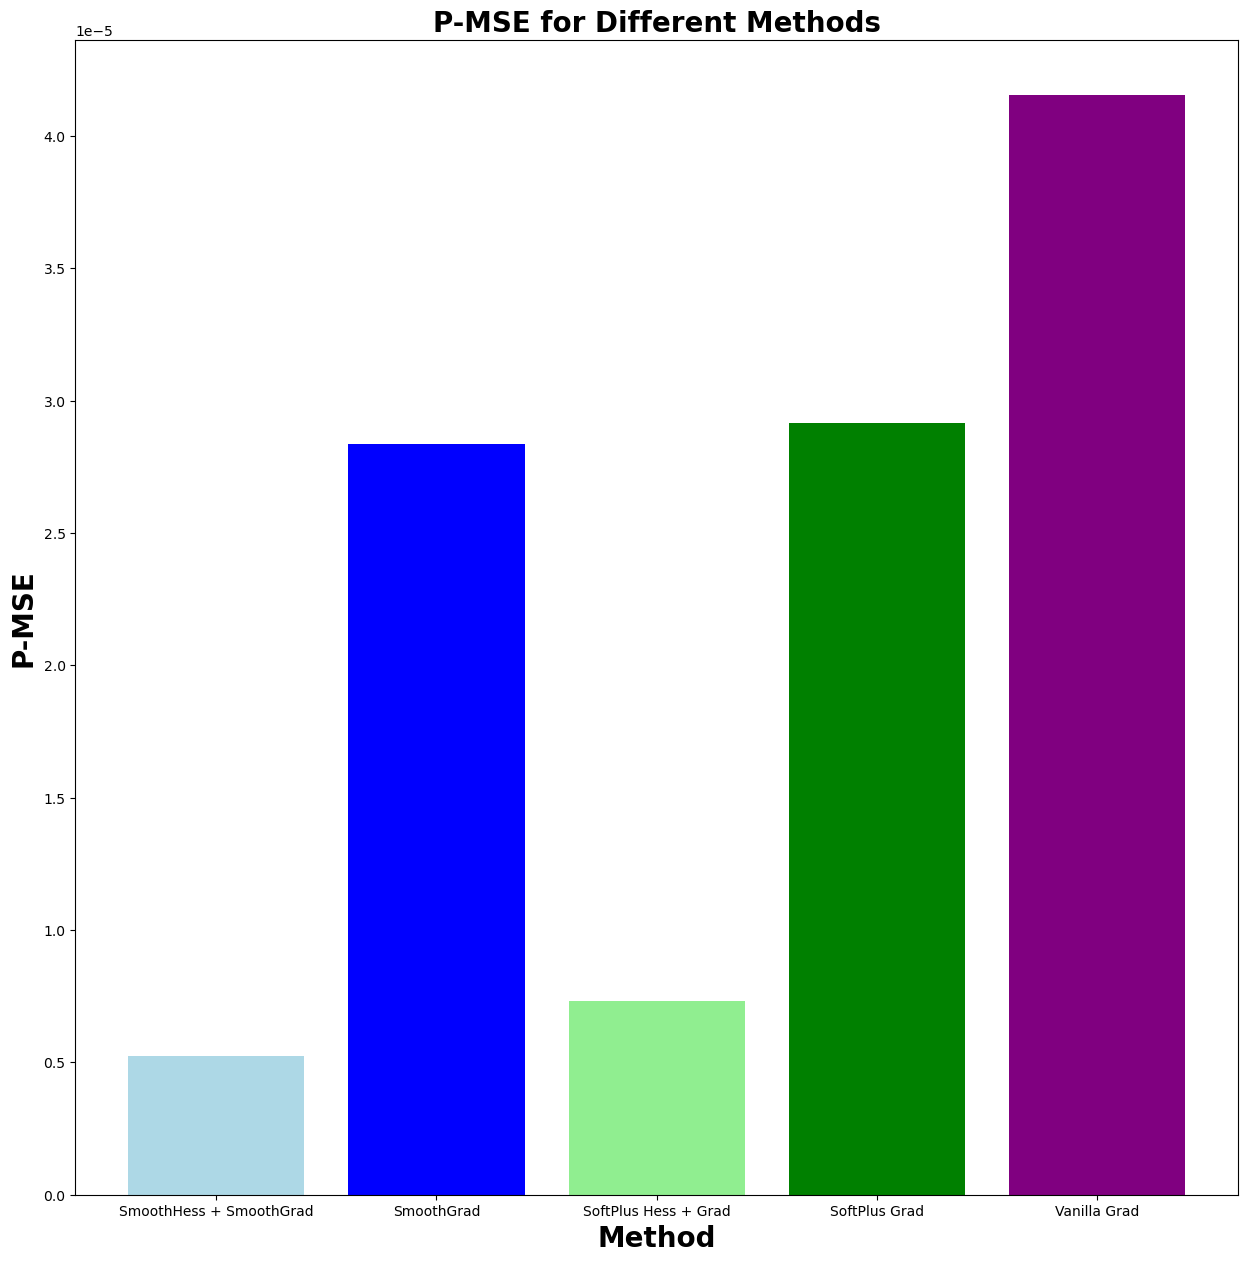

In [41]:
fig = plt.figure(figsize  = (15,15))
methods = ["SmoothHess + SmoothGrad", "SmoothGrad", "SoftPlus Hess + Grad", "SoftPlus Grad", "Vanilla Grad"]
values  = [SmoothHess_PMSE, SmoothGrad_PMSE, SoftPlus_Hess_PMSE, SoftPlus_Grad_PMSE, VanillaGrad_PMSE]
values = [float(val) for val in values]
plt.bar(methods, values, color=['lightblue', 'blue', 'lightgreen', 'green', 'purple'])
plt.title("P-MSE for Different Methods", weight='bold', size = 20)
plt.ylabel("P-MSE", weight='bold', size = 20)
plt.xlabel("Method", weight = "bold", size = 20) 
